# BMW vs Volkswagen

**Hugo Pasqual del Pobil**

El siguiente informe consiste en una comparación y aplicación de modelos VAR y Garch, predicción a futuro y análisis de variables de las cotizadas alemanas BMW y Volkwagen.

Datos de Yahoo Finance entre los periodos 01/01/2009 a 01/10/2010.

### Librerias

Importamos las librerias que vamos a utilizar para el caso práctico.

In [126]:
from yahoofinancials import YahooFinancials
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sktime.utils.plotting import plot_correlations

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

import statsmodels.api as sm
from arch.univariate import ARX
from arch.univariate import ARCH, GARCH

sns.set(rc={'figure.figsize':(11, 4)})

### Datos

Se obtienen los datos de Yahoo Finance mediante un API. Los datos que se utilizan son en el intervalo 2009/01 a 2020/10. Tanto para BMW y Volkswagen, ambos fabricantes de coches alemanes. Cotizan en XETRA.

In [2]:
yf = YahooFinancials('BMW.DE')
data_bmw = yf.get_historical_price_data(
  start_date='2009-01-01',
  end_date='2020-10-01', 
  time_interval='monthly') 
 
bmw = pd.DataFrame(data_bmw['BMW.DE']['prices'])

yf = YahooFinancials('VOW.DE')
data_vow = yf.get_historical_price_data(
  start_date='2009-01-01',
  end_date='2020-10-01', 
  time_interval='monthly') 
 
vow = pd.DataFrame(data_vow['VOW.DE']['prices'])

### Limpieza de datos

Vamos a eliminar algunos datos que no necesitamos y poner la fecha como indice.

In [3]:
bmw['Datetime'] = pd.to_datetime(bmw['date'])
vow['Datetime'] = pd.to_datetime(vow['date'])

In [4]:
bmw = bmw.set_index('Datetime')
vow = vow.set_index('Datetime')

Seleccionamos únicamente el precio ajustado para realizar los cáculos, eliminamos los datos que no utilizamos.

In [5]:
bmw = bmw[['adjclose']]
vow = vow[['adjclose']]

Calculamos el retorno diario logarítmico y lo elevamos al cuadrado para eliminar los valores de retorno negativos.

In [6]:
bmw['log_ret'] =np.log(bmw.adjclose).diff().dropna()
vow['log_ret'] =np.log(vow.adjclose).diff().dropna()

bmw['Squared'] =bmw['log_ret']**2
vow['Squared'] =vow['log_ret']**2

### BMW Visualización Retornos Log

**Volatilidad y Rentabilidad**

Se observa en la evolución del precio y posteriormente los retornos, como BMW muestra mucha volatilidad. Podemos asumir que los retornos tiene media cero. 


Text(0.5, 0.8, 'BMW Volatilidad')

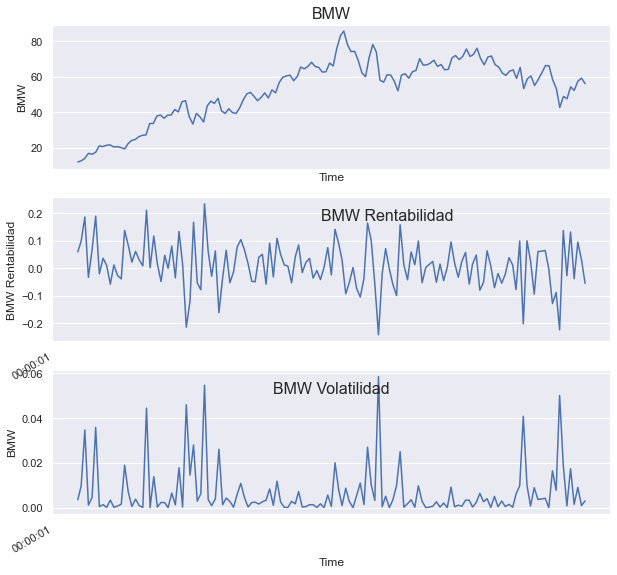

In [7]:
fig = plt.figure(figsize=(10,10))

plt.subplot(311)
ax=bmw.adjclose.plot( linestyle='-')
ax.set_ylabel('BMW')
ax.set_xlabel('Time')
ax.set_title('BMW', y=1, fontsize = 16)

plt.subplot(312)
ax=bmw.log_ret.plot( linestyle='-')
ax.set_ylabel('BMW Rentabilidad')
ax.set_xlabel('Time')
ax.set_title('BMW Rentabilidad', y=0.8, x=0.6,fontsize = 16)

plt.subplot(313)
ax=bmw.Squared.plot( linestyle='-')
ax.set_ylabel('BMW')
ax.set_xlabel('Time')
ax.set_title('BMW Volatilidad', y=0.8, fontsize = 16)

### Volkswagen Visualización Retornos Log

**Volatilidad y Rentabilidad**

Volkswagen a diferencia de BMW, muestra menos volatilidad y unos retornos en media cero con más tenencia a negativos.

Text(0.5, 0.8, 'VOW Volatilidad')

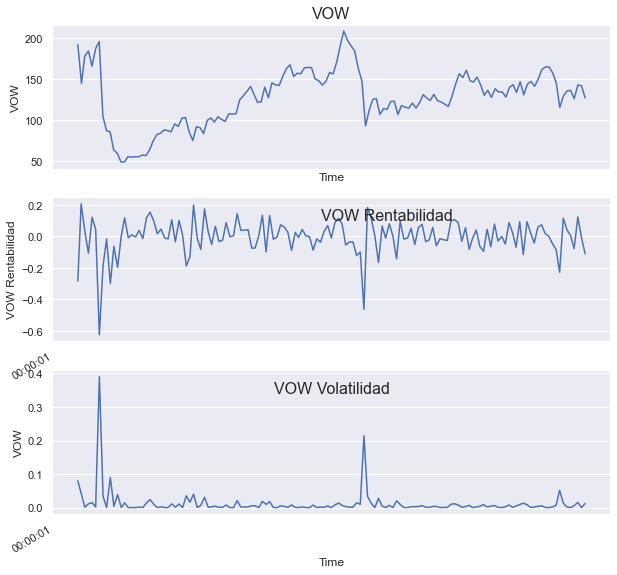

In [8]:
fig = plt.figure(figsize=(10,10))

plt.subplot(311)
ax=vow.adjclose.plot( linestyle='-')
ax.set_ylabel('VOW')
ax.set_xlabel('Time')
ax.set_title('VOW', y=1, fontsize = 16)

plt.subplot(312)
ax=vow.log_ret.plot( linestyle='-')
ax.set_ylabel('VOW Rentabilidad')
ax.set_xlabel('Time')
ax.set_title('VOW Rentabilidad', y=0.8, x=0.6,fontsize = 16)

plt.subplot(313)
ax=vow.Squared.plot( linestyle='-')
ax.set_ylabel('VOW')
ax.set_xlabel('Time')
ax.set_title('VOW Volatilidad', y=0.8, fontsize = 16)

### Test de media cero

Comprobamos el test de media cero para determinar si se rechaza o no la hipótesis de los retornos logarítmicos.

Con un intervalo de confianza del **5%**, no se rechaza la hipótesis.

In [9]:
print('Test media cero BMW')
alpha=0.05
t, p =stats.ttest_1samp(bmw['log_ret'].dropna(),0.0)
print ('Estadítico t:',t)
print ('p-value:',p)

if  p < alpha:
    print (f'Con {alpha} de significación: Rechazamos la hipotesis de media cero.')
else:
    print (f'Con {alpha} de significación: No podemos rechazar la hipotesis de media cero.')
print('--------------------------------------------------')
print('Test media cero VOW')
alpha=0.05
t, p =stats.ttest_1samp(vow['log_ret'].dropna(),0.0)
print ('Estadítico t:',t)
print ('p-value:',p)

if  p < alpha:
    print (f'Con {alpha} de significación: Rechazamos la hipotesis de media cero.')
else:
    print (f'Con {alpha} de significación: No podemos rechazar la hipotesis de media cero.')

Test media cero BMW
Estadítico t: 1.5787270503106619
p-value: 0.11665550353924815
Con 0.05 de significación: No podemos rechazar la hipotesis de media cero.
--------------------------------------------------
Test media cero VOW
Estadítico t: -0.31470054005677656
p-value: 0.7534575604290512
Con 0.05 de significación: No podemos rechazar la hipotesis de media cero.


### BMW ACF, PACF y Ljung-Box Test

1. Test de volatilidad
2. Función de autocorrelación
3. Función parcial de autocorrelación

Se puede observar que al computar el ACF y PACF, los retornos no muestra significancia en los lags de los retornos. Indicando que los retornos pasados no explican los retornos actuales. Se destaca mas autocorrelación en los lags 11, pero se ignoran.

In [10]:
bmw_vol = bmw['Squared'].dropna()
type(bmw.index)

pandas.core.indexes.datetimes.DatetimeIndex

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Squared'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

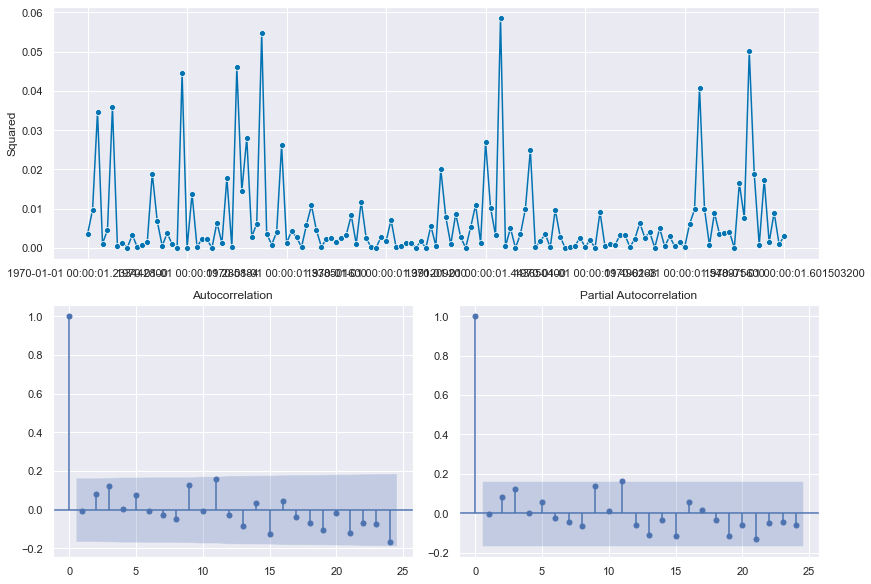

In [11]:
plot_correlations(bmw_vol)

### Volkswagen ACF, PACF y Ljung-Box Test

1. Test de volatilidad
2. Función de autocorrelación
3. Función parcial de autocorrelación

Se puede observar que al computar el ACF y PACF, los retornos no muestra significancia en los lags de los retornos. Indicando que los retornos pasados no explican los retornos actuales. A diferencia de BMW, me mostraba un poco de autocorrelación en lag 11, Volskwagen se mantiene sin significancia en todos los lags.

In [12]:
vow_vol = vow['Squared'].dropna()
type(vow.index)

pandas.core.indexes.datetimes.DatetimeIndex

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Squared'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

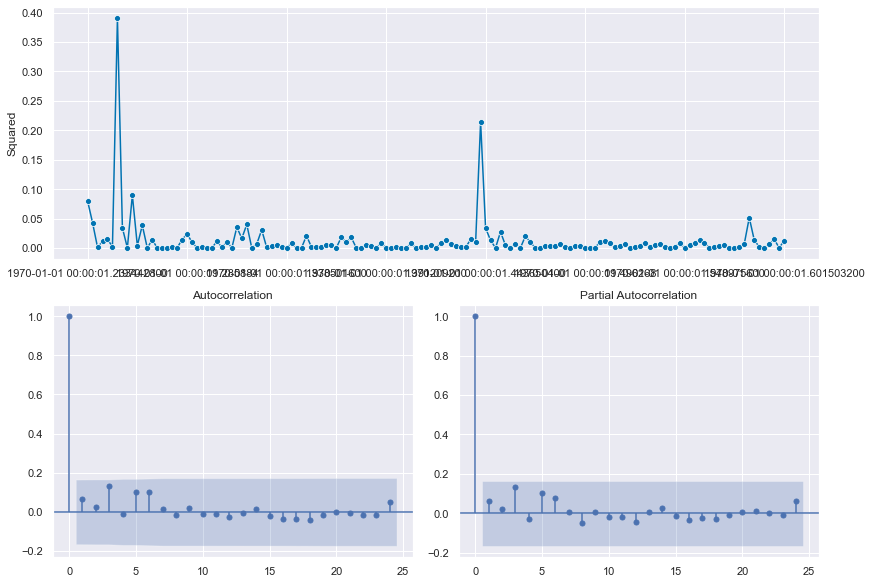

In [13]:
plot_correlations(vow_vol)

### Test de causalidad de Granger

Con este test intentamos comprobar si nuestra serie temporal 1 puede precedir a la serie temporal 2, en nuestro caso BMW y VOW.

El test identifica si una variable antecede a otra en una serie temporal. Que posteriomente se puede utilizar para predecir.

In [14]:
datos = vow
datos['vow_log_ret'] = vow['log_ret']
datos['bmw_log_ret'] = bmw['log_ret']
datos = datos[['vow_log_ret', 'bmw_log_ret']]

datos = datos.dropna()
datos

,vow_log_ret,bmw_log_ret
Datetime,,
1970-01-01 00:00:01.233442800,-0.282816,0.059454
1970-01-01 00:00:01.235862000,0.207274,0.098298
1970-01-01 00:00:01.238536800,0.033710,0.186215
1970-01-01 00:00:01.241128800,-0.105416,-0.033114
1970-01-01 00:00:01.243807200,0.121788,0.067534
...,...,...
1970-01-01 00:00:01.590962400,0.006300,0.131735
1970-01-01 00:00:01.593554400,-0.076849,-0.038025
1970-01-01 00:00:01.596232800,0.123877,0.094978


In [15]:
gc_test = grangercausalitytests(datos[['vow_log_ret', 'bmw_log_ret']], 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1082  , p=0.7427  , df_denom=137, df_num=1
ssr based chi2 test:   chi2=0.1106  , p=0.7395  , df=1
likelihood ratio test: chi2=0.1105  , p=0.7396  , df=1
parameter F test:         F=0.1082  , p=0.7427  , df_denom=137, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7307  , p=0.4835  , df_denom=134, df_num=2
ssr based chi2 test:   chi2=1.5159  , p=0.4686  , df=2
likelihood ratio test: chi2=1.5077  , p=0.4705  , df=2
parameter F test:         F=0.7307  , p=0.4835  , df_denom=134, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9956  , p=0.3971  , df_denom=131, df_num=3
ssr based chi2 test:   chi2=3.1464  , p=0.3696  , df=3
likelihood ratio test: chi2=3.1110  , p=0.3748  , df=3
parameter F test:         F=0.9956  , p=0.3971  , df_denom=131, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7274  , p=0.1479  

Los valores p-value no son cero, con lo que podemos aceptar la hipótesis de que **existe una relación entre las dos variables.**

Sin hacer el test de causalidad se puede asumir que tiene relación, pues ambas cotizan en el mismo mercado y son fabricantes de coches OEM (misma industria). La causalidad no refleja que haya una relación directa entre la evolución de los precios y los retornos.

### Modelo VAR


Lo empleamos para modelizar nuestras series temporales en contextos multivariantes donde hay dependencias dinámicas entre distintas series. Los modelos VAR (modelos autorregresivos vectoriales) lo utilizamos porque las series temporales a modelizar son estacionarias en los retornos.

In [16]:
modelo_var = VAR(datos)

/Users/hpp/Desktop/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Queremos modelizar la dependencia entre los precios y retornos de BMW y Volkswagen. Lógicamente, ambas series estarán correlacionadas; pero esta dependencia no solo será contemporánea (en el mismo instante) sino que también el pasado de BMW puede influir sobre VOW y viceversa (dependencia dinámica). 

In [17]:
modelo_var.select_order(15)

### Análisis de resultados VAR

Nuestro modelo VAR y posteriormente los resultados nos indican:
1. Existe relación entre ambas series temporales
2. El modelo automático unicamente detecta hasta el retardo 2
3. El modelo muestra más relación entre las variables y sus retardos que con la variable que se la compara.
4. Se muestra causalidad en los lags=1, queriendo decir que el retorno de BMW esta muy relacionado con el retorno de VOW del periodo anterior. Siendo las dos series cotizadas del mismo mercado.
5. Posteriormente la significancia se reduce con el aumento de retardos

In [18]:
results = modelo_var.fit(maxlags=15, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Nov, 2021
Time:                     13:31:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.70721
Nobs:                     140.000    HQIC:                  -9.78205
Log likelihood:           297.027    FPE:                5.36372e-05
AIC:                     -9.83328    Det(Omega_mle):     5.14103e-05
--------------------------------------------------------------------
Results for equation vow_log_ret
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.000377         0.009367           -0.040           0.968
L1.vow_log_ret         0.016344         0.102428            0.160           0.873
L1.bmw_log_ret        -0.044967         0.136705  

In [19]:
results = modelo_var.fit(4,trend='c')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Nov, 2021
Time:                     13:31:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.44144
Nobs:                     137.000    HQIC:                  -9.66918
Log likelihood:           302.229    FPE:                5.40983e-05
AIC:                     -9.82509    Det(Omega_mle):     4.76342e-05
--------------------------------------------------------------------
Results for equation vow_log_ret
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.004725         0.009448            0.500           0.617
L1.vow_log_ret         0.031121         0.110203            0.282           0.778
L1.bmw_log_ret        -0.044721         0.142530  

Analizando los resultados, y comprobando la relación entre las variables BMW y VOW. Podemos concluir en que la equación de VOW tiene coeficientes mas altos, aunque negativos, con la variable opuesta BMW. En otras palabras, la relación es muy pequeña o casi insignifcante lo cual nos hace asumir que no hay relación y que ninguna de las cotizadas es perseguidora de la otra.

Los residuos por otro lado muestran dinamismo en ambas ecuaciones.

**Son ruido blanco?**

Existe correlación en los residuos, por lo que se puede asumir que no existe ruido blanco en su totalidad.

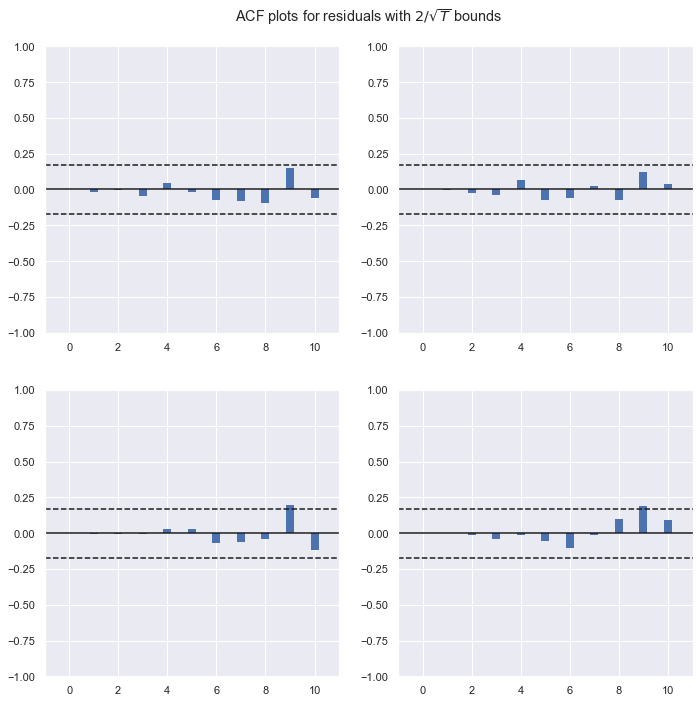

In [129]:
results.plot_acorr();

### Predicción

La predicción de los retornos para ambas variables son constantes, como era de esperar.
Computando los precios tendremos una predicción del valor que puede alcanzar cada variable en un periodo de 5.

In [71]:
lag_order = results.k_ar
pred = results.forecast(datos.values[-lag_order:], 12)
pred

array([[ 0.02049071,  0.02693901],
       [-0.00820542,  0.01494605],
       [-0.02782957, -0.00118677],
       [ 0.00740342,  0.01436209],
       [-0.00483455,  0.009416  ],
       [-0.00956823,  0.00618313],
       [ 0.00050749,  0.01058345],
       [-0.00207664,  0.00948927],
       [-0.00343442,  0.00845552],
       [-0.00088409,  0.00953235],
       [-0.00141126,  0.00932291],
       [-0.00174484,  0.00905453]])

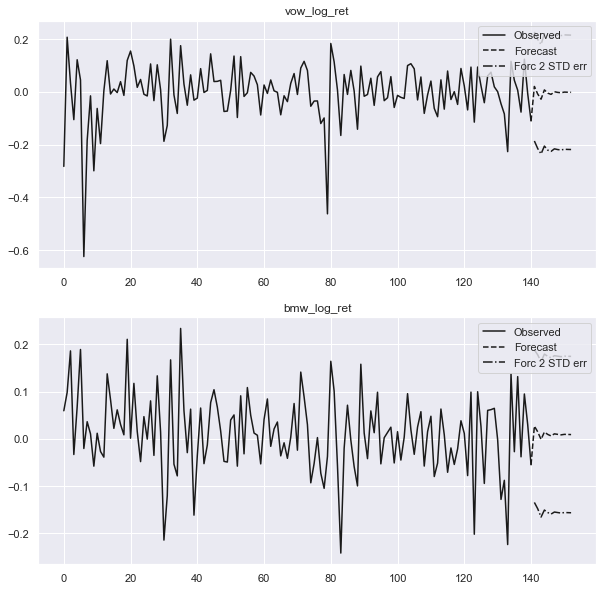

In [128]:
results.plot_forecast(12);

### Predicción precios

Se computa la predicción del precio en el periodo 5.

In [67]:
vow_last_price = vow['adjclose'][-1]

In [68]:
bmw_last_price = bmw['adjclose'][-1]

In [108]:
predvow = (np.exp(np.cumsum(pred[:,0]))*vow_last_price)
print('Predicción 12 periodos:')
print(predvow)

Predicción 12 periodos:
[129.71296401 128.65296916 125.1219734  126.05174119 125.44380884
 124.24925797 124.31232961 124.05444577 123.62912189 123.51987059
 123.3456747  123.13064394]


In [109]:
predbmw = (np.exp(np.cumsum(pred[:,1]))*bmw_last_price)
print('Predicción 12 periodos:')
print(predbmw)

Predicción 12 periodos:
[57.55861305 58.42534801 58.35605154 59.20021399 59.76027594 60.1309261
 60.77069811 61.35011271 61.87105902 62.46365548 63.04872146 63.62219033]


### Comparación precios

A continuación se muestra la comparación de los precios actuales y las predicciones para Noviembre de 2020 (el siguiente mes) y Octubre de 2021 (el año siguiente).

In [104]:
print('Precio VOW a 1/10/2010:')
print(round(vow_last_price, 2))
print('Predicción VOW Noviembre de 2020:')
print(round(predvow[0], 2))

print('Predicción VOW Octubre de 2021:')
print(round(predvow[-1], 2))
print('')

print('Precio BMW a 1/10/2010:')
print(round(bmw_last_price, 2))
print('Predicción BMW Noviembre de 2020:')
print(round(predbmw[0], 2))

print('Predicción BMW Octubre de 2021:')
print(round(predbmw[-1], 2))

Precio VOW a 1/10/2010:
127.08
Predicción VOW Noviembre de 2020:
129.71
Predicción VOW Octubre de 2021:
123.13

Precio BMW a 1/10/2010:
56.03
Predicción BMW Noviembre de 2020:
57.56
Predicción BMW Octubre de 2021:
63.62


### Función de respuesta al impulso

Las bandas incluyen el 0, cual nos indica que el efecto de una variable a la otra tiene significancia.

Calculamos 5 periodos.

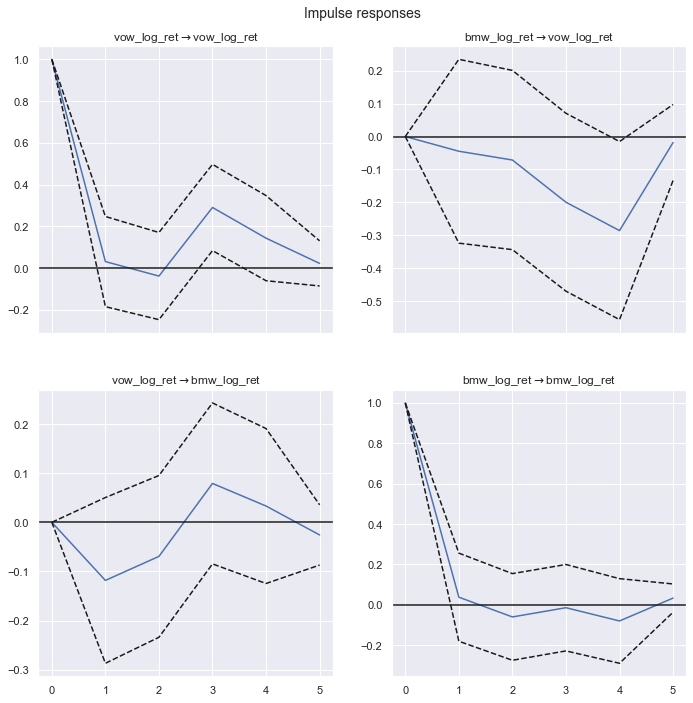

In [130]:
irf = results.irf(5)
irf.plot(orth=False);

### Función de respuesta acumulada

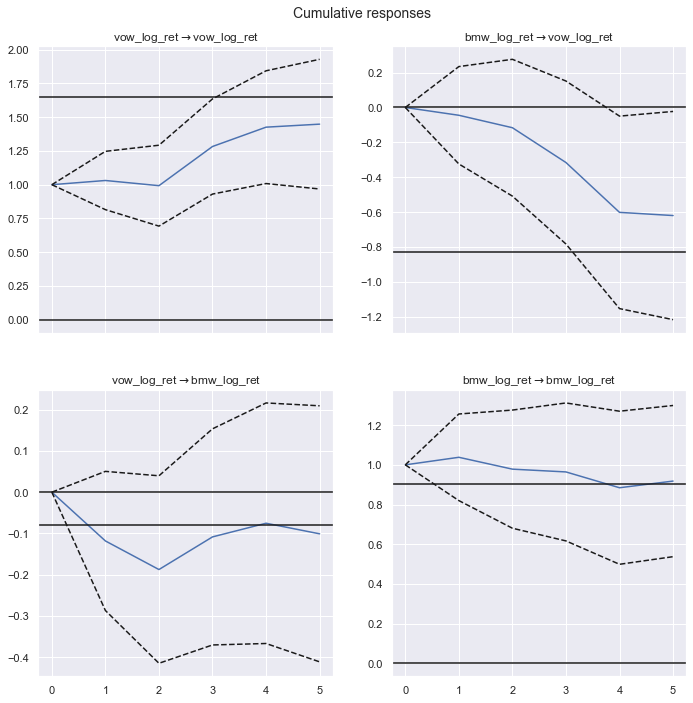

In [132]:
irf.plot_cum_effects(orth=False);

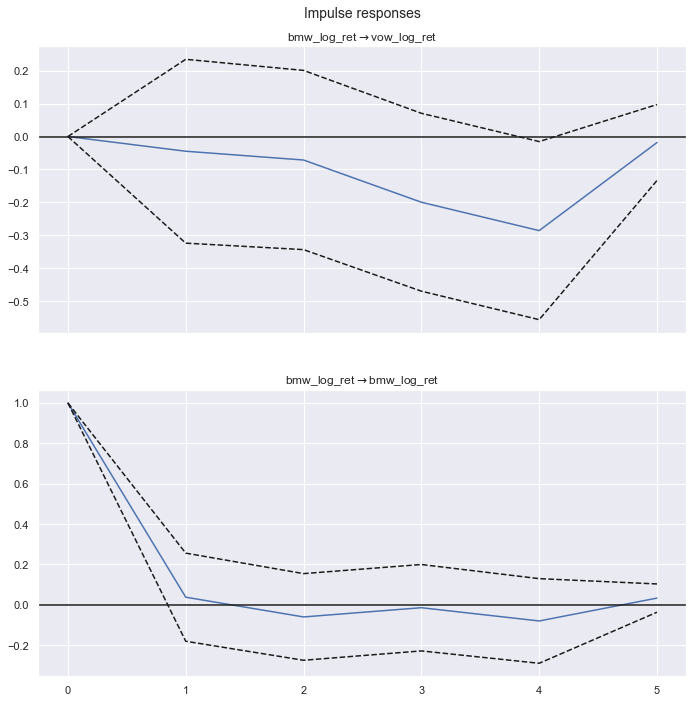

In [133]:
irf.plot(impulse='bmw_log_ret');

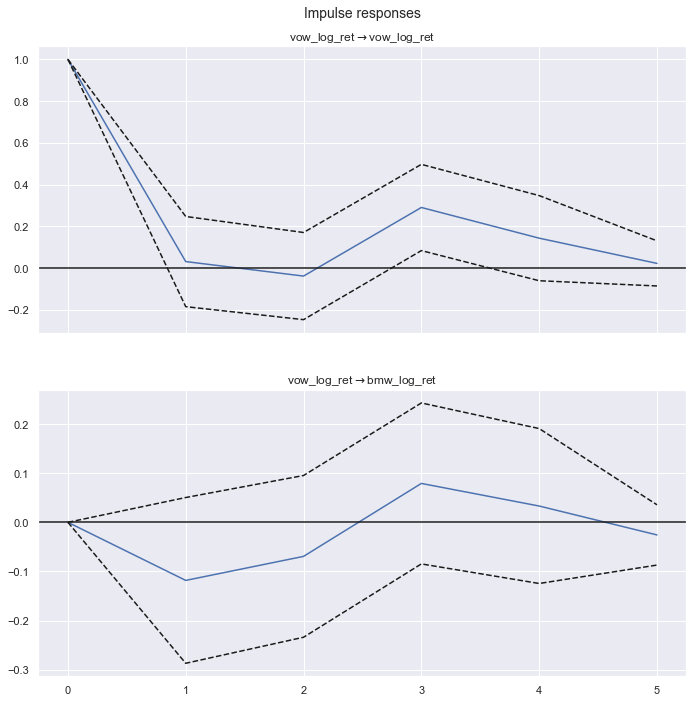

In [134]:
irf.plot(impulse='vow_log_ret');

### Descomposición del error de predicción

In [31]:
fevd = results.fevd(5)
fevd.summary()

FEVD for vow_log_ret
     vow_log_ret  bmw_log_ret
0       1.000000     0.000000
1       0.999232     0.000768
2       0.997295     0.002705
3       0.983002     0.016998
4       0.954755     0.045245

FEVD for bmw_log_ret
     vow_log_ret  bmw_log_ret
0       0.370323     0.629677
1       0.380169     0.619831
2       0.388721     0.611279
3       0.393718     0.606282
4       0.392237     0.607763




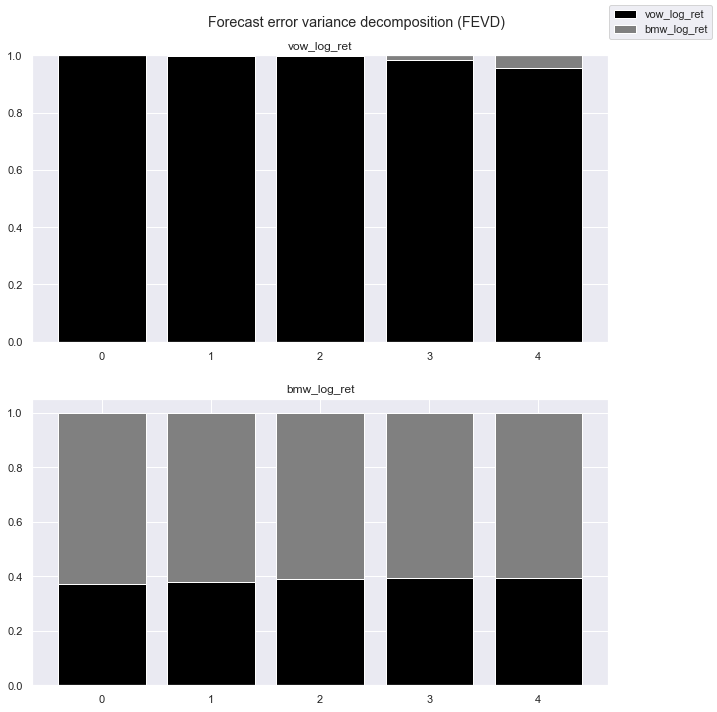

In [135]:
results.fevd(5).plot();

### Análisis de Causalidad de Granger

p-value = 0.499 nos indica que no hay significancia en el test de causalidad.

Fallo en reconocer la hipótesis de causalidad de BMW a Volkswagen.

In [34]:
results.test_causality('bmw_log_ret', 'vow_log_ret', kind='f').summary()

Test statistic,Critical value,p-value,df
0.8438,2.407,0.499,"(4, 256)"


Analizando los resultados, el valor de p disminuye pero sigue indicando no significancia entre las variables de VOW y BMW.

In [36]:
results.test_causality('vow_log_ret', 'bmw_log_ret', kind='f').summary()

Test statistic,Critical value,p-value,df
1.727,2.407,0.144,"(4, 256)"


### Normalidad

In [37]:
results.test_normality().summary()

Test statistic,Critical value,p-value,df
432.7,9.488,0.000,4


#### Análisis Nornalidad

El gráfico parece indicar que los datos de residuos siguen una distribución normal.

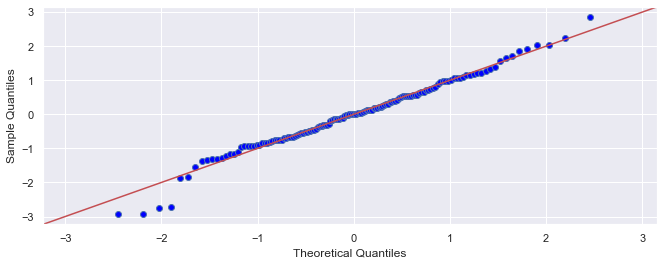

In [44]:
sm.qqplot(bmw_mod1_std_resid,line='45')
plt.show()

### GARCH (1,1)

Anteriomente hemos visto que ambas series muestran volatilidad, utilizamos un modelo GARCH (1,1).

In [38]:
bmw_ar = ARX(100*bmw['log_ret'].dropna(), lags=[1])
print(bmw_ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                log_ret   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                 -0.006
Vol Model:          Constant Variance   Log-Likelihood:               -494.088
Distribution:                  Normal   AIC:                           994.176
Method:            Maximum Likelihood   BIC:                           1003.00
                                        No. Observations:                  140
Date:                Wed, Nov 24 2021   Df Residuals:                      138
Time:                        13:32:37   Df Model:                            2
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          1.1029      0.732      1.506      0.132 [ -0.333,  2.53

In [39]:
vow_ar = ARX(100*vow['log_ret'].dropna(), lags=[1])
print(vow_ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                 -0.007
Vol Model:          Constant Variance   Log-Likelihood:               -531.601
Distribution:                  Normal   AIC:                           1069.20
Method:            Maximum Likelihood   BIC:                           1078.03
                                        No. Observations:                  140
Date:                Wed, Nov 24 2021   Df Residuals:                      138
Time:                        13:32:40   Df Model:                            2
                                Mean Model                               
                  coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------------------------------------------------------------
Const          -0.0934      0.905     -0.103      0.918 [ -1.867,  

**Modelo GARCH(1,1)**

In [40]:
bmw_ar.volatility = GARCH(p=1,q=1)
bmw_res = bmw_ar.fit(update_freq=0, disp="off")
print(bmw_res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                log_ret   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                 -0.007
Vol Model:                      GARCH   Log-Likelihood:               -492.074
Distribution:                  Normal   AIC:                           994.147
Method:            Maximum Likelihood   BIC:                           1008.86
                                        No. Observations:                  140
Date:                Wed, Nov 24 2021   Df Residuals:                      138
Time:                        13:32:42   Df Model:                            2
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          1.1233      0.662      1.698  8.951e-02 [ -0.173,  2.42

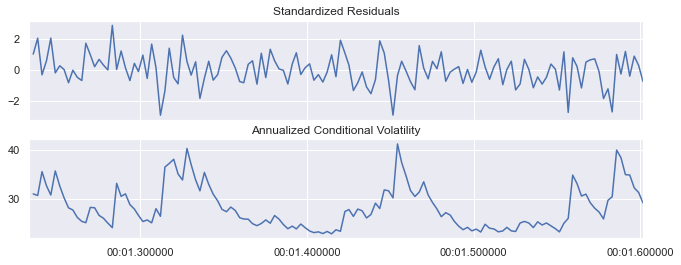

In [41]:
fig_bmw = bmw_res.plot(annualize='M')

In [42]:
bmw_mod1_std_resid=(bmw_res.resid / bmw_res.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()

### Análisis Residuos Garch BMW

Se observa que los residuos tiene poca autocorrelación y se asume que son ruido blanco. A excepción del lag 9 que es significante. Se ignora.

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

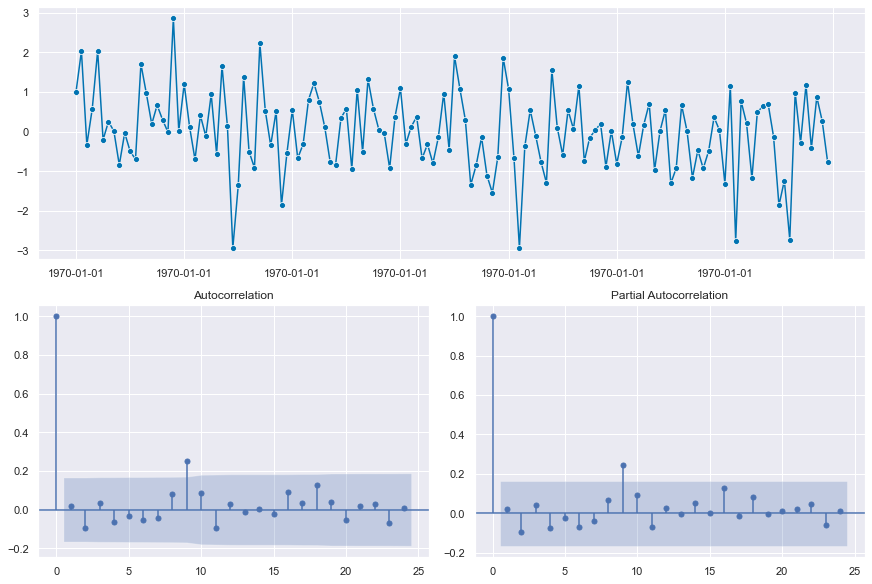

In [43]:
plot_correlations(bmw_mod1_std_resid)